$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 6: YOLO - Objects Detection
<a id=part6></a>

In this part we will use an object detection architecture called YOLO (You only look once) to detect objects in images. We'll use an already trained model weights (v5) found here: https://github.com/ultralytics/yolov5

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the YOLO model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")
model.to(device)
# Images
img1 = 'imgs/DolphinsInTheSky.jpg'  
img2 = 'imgs/cat-shiba-inu-2.jpg' 

Using cache found in /home/noam.moshe/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-8 Python-3.8.12 torch-1.10.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /home/noam.moshe/.cache/torch/hub/requirements.txt not found, check failed.


## Inference with YOLO
<a id=part6_1></a>

You are provided with 2 images (img1 and img2).
**TODO**:
1. Detect objects using the YOLOv5 model for these 2 images.
2. Print the inference output with bounding boxes.
3. Calculate the number of pixels within a bounding box and the number in the background.
   
   **Hint**: Given you stored the model output in a varibale named 'results', you may find 'results.pandas().xyxy' helpful 
4. Look at the inference results and answer the question below.


In [2]:
def get_bboxes_intersection(box1, box2):
    """
    Calculate the number of pixels that intersect between two bounding boxes.
    :param box1: row in pandas dataframe with columns: xmax, xmin, ymax, ymin
    :param box2: row in pandas dataframe with columns: xmax, xmin, ymax, ymin
    :return: number of pixels of intersection (int)
    """
    # get the coordinates of the intersection box
    x_left = max(box1['xmin'], box2['xmin'])
    x_right = min(box1['xmax'], box2['xmax'])
    y_bottom = max(box1['ymin'], box2['ymin'])
    y_top = min(box1['ymax'], box2['ymax'])

    if x_right <= x_left or  y_top <= y_bottom:
        return 0

    return (x_right - x_left) * (y_top - y_bottom)

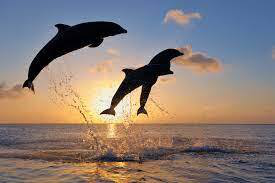

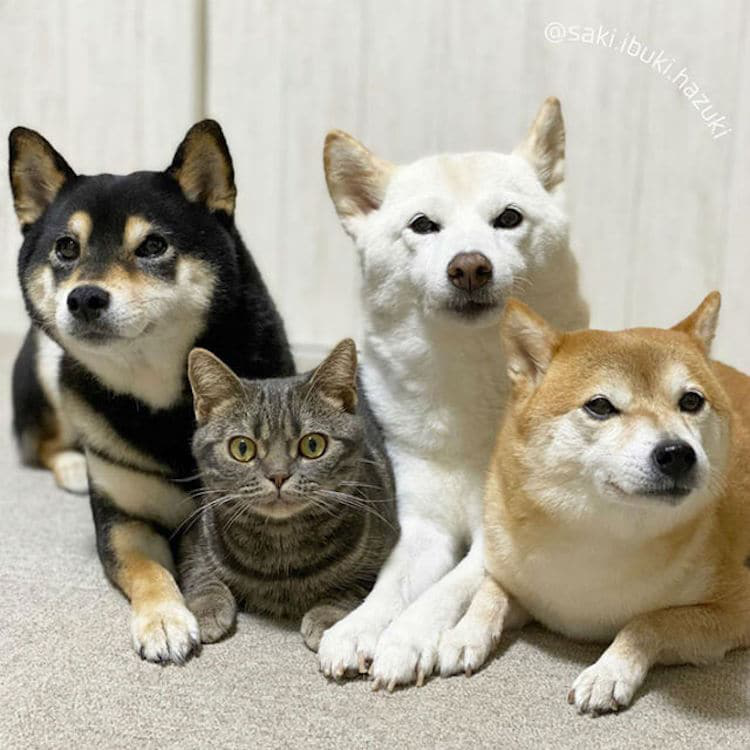

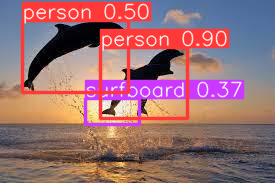

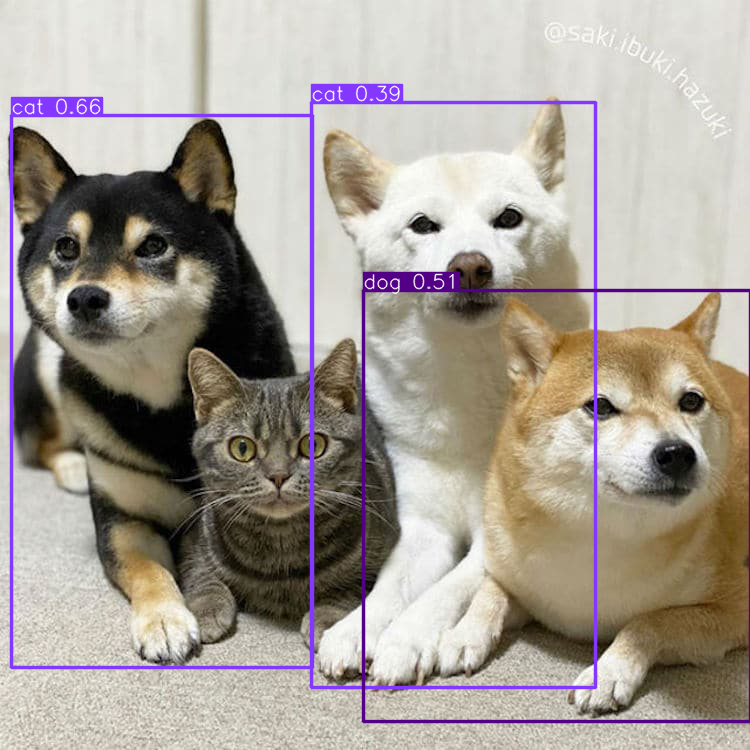


=============================================== Image 1 ===============================================

Pixels bounded by boxes:  11085.333271709653
Pixels in background:  39239.66672829035

=============================================== Image 2 ===============================================

Pixels bounded by boxes:  313376.7320882534
Pixels in background:  249123.26791174657


In [10]:
#Insert the inference code here.
from matplotlib import pyplot as plt
from PIL import Image

with torch.no_grad():    
    image1, image2 = Image.open(img1), Image.open(img2)
    image1.show()
    image2.show()

    img1_bboxes, img2_bboxes = model(image1), model(image2)
    img1_bboxes.show()
    img2_bboxes.show()
    
    for df, image in zip([img1_bboxes.pandas().xyxy[0], img2_bboxes.pandas().xyxy[0]], [image1, image2]):
        pixels_in_boxes = ((df['xmax'].to_numpy() - df['xmin'].to_numpy()) * (df['ymax'].to_numpy() - df['ymin'].to_numpy())).sum()
        # remove intersection area
        for index1, box1 in df.iterrows():
            for index2, box2 in df.iterrows():
                if index1 is not index2:
                    pixels_in_boxes -= get_bboxes_intersection(box1, box2)
        pixels_outside_boxes = image.size[0] * image.size[1] - pixels_in_boxes
        if image == image1:
            print("\n=============================================== Image 1 ===============================================\n")
        else:
            print("\n=============================================== Image 2 ===============================================\n")
        print(f"Pixels bounded by boxes: ", pixels_in_boxes)
        print(f"Pixels in background: ",  pixels_outside_boxes)

In [4]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1

Analyze the inference results of the 2 images. 
1. How well did the model detect the objects in the pictures?
2. What can possibly be the reason for the model failures? suggest methods to resolve that issue.

In [5]:
display_answer(hw2.answers.part6_q1)



**Your answer:**

1. The YOLOv5 model with the trained weights performed poorly for both pictures.
For the first picture, the model received an image of 3 jumping dolphins and detected instead 2 of the as person, and one of them as surfboard.
Even worse, one of this predictions has confidence value grater than 0.9.
For the second picture, the model received and image of 3 dogs and a cat and detected 2 of the dogs as cats, one dog as an acctual dog, and complitly missed the cat in the picture.

2. We believe that the reason for the model failures for the first picture is due to the fact that the model has no class "dolphin" (can be seen at https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml).

It is highly likely that the detection of one dolphin as a surfboard occurs since pictures with an actual surfboard in the training set has similar backgroand as in the given picture, that contains pixel representation of sea and sunset.  
Meaning that the pixels surrounding the dolphin in the first picture are similar to those who surround pictures with surfboards that the model alreay saw. 
A reasonable method for addressing the model failures for the first picture is adding a new class of "dolphin" to the model, with relevant samples.
every other approach will obviously end up in a wrong classification of the objects in this pictures.

As for the second picture, we noticed that the bounding boxes of both of the dogs that the model detected as cats, contains pixels that capture the cat in that picture.   
Hence, a possible reason for these wrong detections is that there are more labeled samples with cat objects then with dog objects, meaining that in the training process the model saw more cats then dogs.
It makes sense because both of this bounding boxes contain pixels of an actual cat, and apparently the prediction of each of them is deermined by those pixels.
As for the third dog, it's predicted bounding box contains a very small portion of a cat, and he indeed detected correctly by the model.
But if so, why the model didn't just detect the single cat in the picture and ignore this 2 dogs? It may happened because the color change between the different dogs and the background, that made the model to still predict 3 object in the picture.  
A reasonable method for addressing this failures is to add samples with dog objects to the training set.
Another possible reason, is that the objects in this picture is pretty dense, especially the cat in the picture that most of it's background is acctualy from the dogs in the picture.
Some possible methods for this are to add "dense" samples to the training set, take smaller kernels in the convolutional layers, and perhaps trying to predict smaller boxes.


## Creative Detection Failures

<a id=part6_2></a>

Object detection pitfalls could be, for example: **occlusion** - when the objects are partially occlude, and thus missing important features, **model bias** - when a model learn some bias about an object, it could recognize it as something else in a different setup, and many others like **Deformation**, **Illumination conditions**, **Cluttered** or **textured background and blurring** due to moving objects.

**TODO**: Take pictures and that demonstrates 3 of the above object detection pitfalls, run inference and analyze the results.

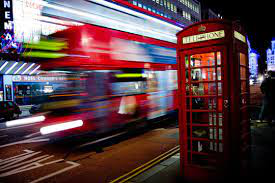

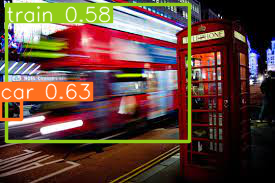

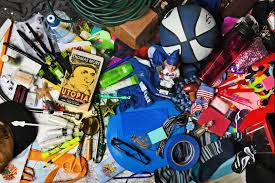

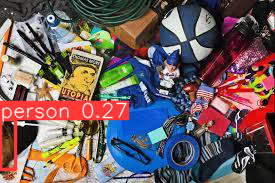

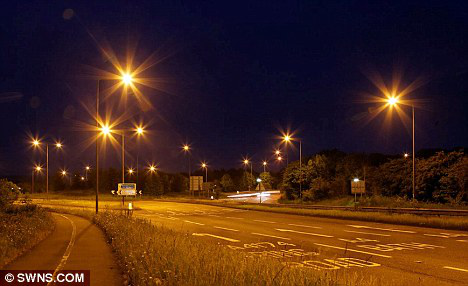

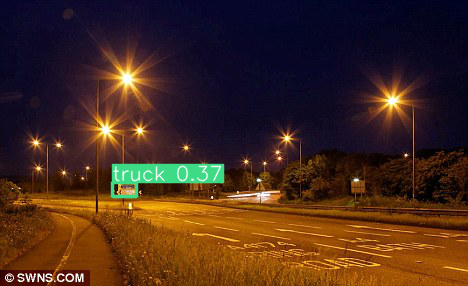

In [6]:
#Insert the inference code here.
img_blurring_moving_object = 'imgs/blurred_bus.jpeg' 
Image.open(img_blurring_moving_object).show()
model(img_blurring_moving_object).show()

cluttered_objects = 'imgs/cluttered_culprits.jpeg' 
Image.open(cluttered_objects).show()
model(cluttered_objects).show()

illumination_conditions = 'imgs/street_lights.jpg' 
Image.open(illumination_conditions).show()
model(illumination_conditions).show()

### Question 3

Analyize the results of the inference. 
1. How well did the model detect the objects in the pictures? explain.


In [7]:
display_answer(hw2.answers.part6_q3)



**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



## Bonus 
<a id=part6_3></a>

Try improving the model performance over poorly recognized images by changing them. 
Describe the manipulations you did to the pictures.

In [8]:
#insert bonus code here

In [9]:
display_answer(hw2.answers.part6_bonus)



**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

